# 初心者のための時系列間の因果関係検出
##  ～らくらくノンパラメトリック・非定常・非線形・多変量に対応～

今回はエンジニア向けに時系列間の因果関係検出に関する論文「A Nonlinear Causality Estimator Based on Non-Parametric Multiplicative Regression」(以降「参考１」)を紹介したいと思います。数学は四則計算レベルで、高度な知識は不要です。



## 概要
本来、時系列間の因果関係検出は時系列解析のエキスパートの聖域でした。初心者が安易に同じ因果関係検出ツールを使っても、見せかけや偽の因果関係を得てしまうケースが多いではないでしょうか。なぜかというと、因果関係を検証する前に予測モデル（多くの場合は様々な自己回帰）を構築する必要があるからです。この作業はエキスパートと初心者とではモデルの質がかなり違う方が多いのではないでしょうか。因果関係の結論はモデルの質に依存しますので従来の因果関係検出タスクは初心者には優しくありません。かなり鬼門だと筆者は思います。

直近、偶然にも、目立たない参考１のような珍しい方法に出くわして、工学的な問題解決の思考回路が大変素晴らしいと思いました。因果関係パターンを検出するのに必要十分な作業以上でも、以下でもなく、省エネエンジニアリング精神に満ちています。ただし、参考１の引用、支持、批判の痕跡がまだ出ておりません。著者のプロフィールを見た限り、医療用分野のコンテストで受賞した実績があって、優秀なようです。今回、ご紹介する技術は学術的な価値の根拠がありませんが、たまにはこのような原石的な技術を知っておいても損はないと思います。

一番印象に残るポイントは、これが初心者にも優しい技術といったところです。　


## 参考1の貢献ポイント

参考１の論文は因果関係検出に関する下記の課題を解決しようとして報告されたものです。（多少筆者の意見が入ります）

1. **パラメトリック手法**：　データの性質をパラメトリック的に説明できると仮定し、解析的にかつエレガントに解くような手法では、利用可能な条件に一致しない場合は無力です。ここはノンパラメトリック的に、データはデータなりに、本質を語ってもらいたいものです。
2. **定常性・線形性**：　グレンジャー因果関係とその心を継承した研究、特に自己回帰モデルベースでは、大抵、時系列の定常性や線形性が必要です。また、非線形や非定常なデータに対して、なんらかの変換やカーネルの導入を要する手法も多々あります。何れも初心に優しくありません。
3. **多変量対応**： 元々のグレンジャー因果関係は２つの時系列の因果関係を検証するもので第三やそれ以上の時系列を考慮できるように一苦労して対応する必要があります。
4. **予測モデル構築**：　専門的な知識が要してあるため初心者には難しい又は無理です。また、モデルの過学習問題を防ぐ対策が必要としています。
5. **予測モデルなし**：　移動エントロピー(Transfer Entropy: TE)や相互情報量系は確か、明確なモデルが不要だが、因果関係としての用途は参考２で様々な問題が指摘されています。是非、この移動エントロピーの公開処刑を一読いただければと思います。少なくとも、基本的なTEは定常性を必要としています。非定常データに対応可能なTE系手法もありますが、かなり苦労します。


参考１はグレンジャー因果関係の伝統を引き継ぎながらこれらの問題を克服する方法を提案しています。アプローチとしては（正確な）モデル構築とモデルなしのちょうど真ん中くらいです。　はたしてそのような効果があるのでしょうか、ご一緒に検証していきましょう。

#### ※注意
サンプルコードはJulia言語バージョン0.5.2でこの原稿を作成しました。また、実験のため、ソースコードの最適化を考慮しておりませんのでご容赦下さい。

#### ※おことわり
ここでご紹介する技術は弊社で提供している商品に組み込まれたり、参考したり、していません。
すべては筆者自身の意見であり、内容の正確さの保証もありません。

### Granger 因果関係のおさらい

時系列Yから時系列XへのGranger因果性ある(Y→X)というのは時系列Xの現在までのデータだけでモデルを作成するより時系列Yの現在までのデータをも取り組んだ方が、有意により正確なXの予測モデルが構築できるということです。Granger因果性の定量測定は下記の式の通りです。σ^2はモデル残差の分散を表しています。伝統的なGranger因果関係検定（Y→X）は、超簡略化にいうと、時系列Y付きモデルの残差の分散が時系列Yなしモデルより有意に小さいかどうかの検定です。Granger因果性には因と果の方向があります。逆方向の測定は式のXとYを入れ替えるだけで済むのです。

In [1]:
display("text/html", """<math id="M1"><mtable columnalign="left"><mtr><mtd><mi mathsize="10.5pt" mathcolor="black">G</mi><mi mathsize="10.5pt" mathcolor="black">C</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">→</mo><mi mathsize="10.5pt" mathcolor="black">X</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mi mathsize="10.5pt" mathcolor="black">l</mi><mi mathsize="10.5pt" mathcolor="black">o</mi><mi mathsize="10.5pt" mathcolor="black">g</mi><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mfrac><mrow><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">σ</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">X</mi><mo mathsize="10.5pt" mathcolor="black">∕</mo><mi mathsize="10.5pt" mathcolor="black">X</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup></mrow><mrow><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">σ</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">X</mi><mo mathsize="10.5pt" mathcolor="black">∕</mo><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">X</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi></mrow><mo stretchy="false">)</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup></mrow></mfrac></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

G C ( Y → X ) = l o g ( σ X ∕ X 2 σ X ∕ ( X , Y ) 2 ) ( 1 )

参考１は伝統的なGranger因果性の概念を継承したいけれど、データの性質をなんらかの型にはめたくないし、多変数間の関係をも明示的に仮定したくない。そこで救いとなるのが「Non-Parametric Multiplicative Regression: NPMR」という生態学の専門家が提案したモデルです。詳細は参考３をご覧ください。参考１が伝統のGranger因果性検定の自己回帰モデルをこのNPMRモデルですり替えることで、一気に、パラメトリック的な手法、定常性・線形性、多変量、正確なモデル構築、様々な課題から解放されます。

さて、NPMRモデルはどんなものか、軽く勉強しましょう。
NPMRモデルは目的の時系列Yを下記のような予測因子である多変量時系列Xで予測したい場合、予測値は式（２）で求めます。
パッと見でちょっと掛け算と足し算で重み付き平均を計算するような感じですね。
重みは予測因子データ同士の距離で決めているようです。


In [2]:
display("text/html","""<math id="M2"><mrow><mstyle mathvariant="bold" mathsize="normal"><mi mathsize="10.5pt" mathcolor="black">X</mi></mstyle><mo mathsize="10.5pt" mathcolor="black">=</mo><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mtable><mtr><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub></mrow></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub></mrow></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋯</mo></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">m</mi></mrow></msub></mrow></mtd></mtr><mtr><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub></mrow></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub></mrow></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋯</mo></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">m</mi></mrow></msub></mrow></mtd></mtr><mtr><mtd><mo mathsize="10.5pt" mathcolor="black">⋮</mo></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋮</mo></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋱</mo></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋮</mo></mtd></mtr><mtr><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mi mathsize="10.5pt" mathcolor="black">T</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub></mrow></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mi mathsize="10.5pt" mathcolor="black">T</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub></mrow></mtd><mtd><mo mathsize="10.5pt" mathcolor="black">⋯</mo></mtd><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mi mathsize="10.5pt" mathcolor="black">T</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">m</mi></mrow></msub></mrow></mtd></mtr></mtable></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></math>""")

X = ( x 1 , 1 x 1 , 2 ⋯ x 1 , m x 2 , 1 x 2 , 2 ⋯ x 2 , m ⋮ ⋮ ⋱ ⋮ x T , 1 x T , 2 ⋯ x T , m )

変数Xの2つの点の重みは下記の式のように計算します。

In [3]:
display("text/html","""<math id="M4"><mtable columnalign="left"><mtr><mtd><msub><mrow><mi mathsize="10.5pt" mathcolor="black">w</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">=</mo><msup><mrow><mi mathsize="10.5pt" mathcolor="black">e</mi></mrow><mrow><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">5</mn><msup><mrow><mrow><mo mathsize="10.5pt" mathcolor="black">[</mo><mrow><mrow><mo stretchy="false">(</mo><mrow><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">-</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">∕</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">σ</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub></mrow><mo mathsize="10.5pt" mathcolor="black">]</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msup></mrow></msup></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">3</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

w i , j = e - 0 . 5 [ ( x i , j - x t , j ) ∕ σ j ] 2 ( 3 )

関数のコードはこのように書けます。

In [4]:
function calDist(x)
    exp(-0.5*x^2)
end

calDist (generic function with 1 method)

In [5]:
display("text/html","""<math id="M3"><mtable columnalign="left"><mtr><mtd><msub><mrow><mi mathsize="10.5pt" mathcolor="black">ŷ</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">=</mo><mfrac><mrow><munderover accentunder="false" accent="false"><mrow><mo mathsize="10.5pt" mathcolor="black">∑</mo></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">≠</mo><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">T</mi></mrow></munderover><msub><mrow><mi mathsize="10.5pt" mathcolor="black">y</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi></mrow></msub><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><munderover accentunder="false" accent="false"><mrow><mo mathsize="10.5pt" mathcolor="black">∏</mo></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">j</mi><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">m</mi></mrow></munderover><msub><mrow><mi mathsize="10.5pt" mathcolor="black">w</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow><mrow><munderover accentunder="false" accent="false"><mrow><mo mathsize="10.5pt" mathcolor="black">∑</mo></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">,</mo><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">≠</mo><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">T</mi></mrow></munderover><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><munderover accentunder="false" accent="false"><mrow><mo mathsize="10.5pt" mathcolor="black">∏</mo></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">j</mi><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">m</mi></mrow></munderover><msub><mrow><mi mathsize="10.5pt" mathcolor="black">w</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mi mathsize="10.5pt" mathcolor="black">j</mi></mrow></msub></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mfrac></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">2</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

ŷ t = ∑ i = 1 , i ≠ t T y i ( ∏ j = 1 m w i j ) ∑ i = 1 , i ≠ t T ( ∏ j = 1 m w i j ) ( 2 )

式（２）を実装するとこんな感じになります。

In [6]:
function pred(X,Y,σ;cross_validate=true)
    T = length(Y)
    upper = zeros(T)
    lower = zeros(T)
    for t=1:T, i=1:T
        if cross_validate && i == t continue end
        prodw = prod(calDist.((X[i,:] - X[t,:]) ./ σ))
        lower[t] += prodw
        upper[t] += prodw*Y[i]
    end
    upper ./ lower
end

pred (generic function with 1 method)

参考１では、XiからYへの因果性は式（５）で評価します。

In [7]:
display("text/html","""<math id="M6"><mtable columnalign="left"><mtr><mtd><msub><mrow><mi mathsize="10.5pt" mathcolor="black">C</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">N</mi><mi mathsize="10.5pt" mathcolor="black">P</mi><mi mathsize="10.5pt" mathcolor="black">M</mi><mi mathsize="10.5pt" mathcolor="black">R</mi></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><msub><mrow><mi mathsize="10.5pt" mathcolor="black">X</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">→</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mi mathsize="10.5pt" mathcolor="black">l</mi><mi mathsize="10.5pt" mathcolor="black">o</mi><mi mathsize="10.5pt" mathcolor="black">g</mi><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mfrac><mrow><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">σ</mi></mrow><mrow><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mover accent="true"><mrow><mstyle mathvariant="bold"><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>Y</mtext></mstyle></mstyle></mrow><mo mathsize="10.5pt" mathcolor="black">~</mo></mover></mrow><mo stretchy="false">)</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup></mrow><mrow><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">σ</mi></mrow><mrow><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mrow><mo stretchy="false">(</mo><mrow><mover accent="true"><mrow><mstyle mathvariant="bold"><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>Y</mtext></mstyle></mstyle></mrow><mo mathsize="10.5pt" mathcolor="black">~</mo></mover><mo mathsize="10.5pt" mathcolor="black">,</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">X</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi></mrow></msub></mrow><mo stretchy="false">)</mo></mrow></mrow><mo stretchy="false">)</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup></mrow></mfrac></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">5</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

C N P M R ( X i → Y ) = l o g ( σ ( Y , Y ~ ) 2 σ ( Y , ( Y ~ , X i ) ) 2 ) ( 5 )

次に条件付き因果性に対応します。例えば第三の時系列Zを式（４）のように遅延エンベディングの集合が得られるとします。実装しますと下記となります。

In [8]:
function Cnpmr(Xy,Xxy,Yy;σy=NaN,σxy=NaN)
    Ŷy = pred(Xy,Yy,isnan(σy) ? ones(size(Xy)[2]) : σy)
    Ŷxy = pred(Xxy,Yy,isnan(σxy) ? ones(size(Xxy)[2]) : σxy)
    log(var(Ŷy-Yy)/var(Ŷxy-Yy))
end

Cnpmr (generic function with 1 method)

In [9]:
display("text/html","""<math id="M5"><mtable columnalign="left"><mtr><mtd><msub><mrow><mover accent="true"><mrow><mi mathsize="10.5pt" mathcolor="black">z</mi></mrow><mo mathsize="10.5pt" mathcolor="black">~</mo></mover></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">=</mo><mrow><mo mathsize="10.5pt" mathcolor="black">{</mo><mrow><msub><mrow><mi mathsize="10.5pt" mathcolor="black">z</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">,</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">z</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mi mathsize="10.5pt" mathcolor="black">τ</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">,</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">z</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">2</mn><mi mathsize="10.5pt" mathcolor="black">τ</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">,</mo><mo mathsize="10.5pt" mathcolor="black">…</mo><mo mathsize="10.5pt" mathcolor="black">,</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">z</mi></mrow><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">d</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mi mathsize="10.5pt" mathcolor="black">τ</mi></mrow></msub></mrow><mo mathsize="10.5pt" mathcolor="black">}</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">4</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

z ~ t = { z t , z t - τ , z t - 2 τ , … , z t - ( d - 1 ) τ } ( 4 )

この時、条件付き因果性は式（６）で評価します。

In [10]:
display("text/html","""<math id="M7"><mrow><mtable><mtr><mtd><mrow><msub><mi mathsize="10.5pt" mathcolor="black">C</mi><mrow><mi mathsize="10.5pt" mathcolor="black">N</mi><mi mathsize="10.5pt" mathcolor="black">P</mi><mi mathsize="10.5pt" mathcolor="black">M</mi><mi mathsize="10.5pt" mathcolor="black">R</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><msub><mi mathsize="10.5pt" mathcolor="black">X</mi><mi mathsize="10.5pt" mathcolor="black">i</mi></msub><mo mathsize="10.5pt" mathcolor="black">→</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">/</mo><mstyle mathvariant="bold" mathsize="normal"><mi mathsize="10.5pt" mathcolor="black">Z</mi></mstyle><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mi mathsize="10.5pt" mathcolor="black">l</mi><mi mathsize="10.5pt" mathcolor="black">o</mi><mi mathsize="10.5pt" mathcolor="black">g</mi><mrow><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mfrac><mrow><msubsup><mi mathsize="10.5pt" mathcolor="black">σ</mi><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mstyle mathvariant="bold" mathsize="normal"><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">˜</mo></mover></mstyle><mo mathsize="10.5pt" mathcolor="black">,</mo><mstyle mathvariant="bold" mathsize="normal"><mi mathsize="10.5pt" mathcolor="black">Z</mi></mstyle><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup></mrow><mrow><msubsup><mi mathsize="10.5pt" mathcolor="black">σ</mi><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">,</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mstyle mathvariant="bold" mathsize="normal"><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">˜</mo></mover></mstyle><mo mathsize="10.5pt" mathcolor="black">,</mo><msub><mstyle mathvariant="bold" mathsize="normal"><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">X</mi><mo mathsize="10.5pt" mathcolor="black">˜</mo></mover></mstyle><mi mathsize="10.5pt" mathcolor="black">i</mi></msub><mo mathsize="10.5pt" mathcolor="black">,</mo><mstyle mathvariant="bold" mathsize="normal"><mi mathsize="10.5pt" mathcolor="black">Z</mi></mstyle><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup></mrow></mfrac></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd><mtd><mrow><mrow><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">(</mo><mn mathsize="10.5pt" mathcolor="black">6</mn><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd></mtr></mtable></mrow></math>""")

C N P M R ( X i → Y / Z ) = l o g ( σ ( Y , ( Y ˜ , Z ) ) 2 σ ( Y , ( ( Y ˜ , X ˜ i , Z ) ) 2 ) ( 6 )

条件付きの対応は、入力データの形成を整理するだけで、特に評価関数を書き換えることなく上記の実装のまま流用できるのは参考１の結構自慢したポイントでもあると論文を読んでいて感じました。因みにデータを整理するコードは下記のとおりです。なぜか計算部分より長いです。

In [11]:
function makeDataset(fromX::Array{Float64,2},
                toY::Array{Float64,2},d;Z=Array{Float64}(0,2))
    T = length(toY)-d
    Xy = vcat([toY[i:-1:(i-d+1)]' for i=d:(d+T-1)]...)
    if size(Z)[1] > 0
        Xz = vcat([collect((Z[i:-1:(i-d+1),:]'...))' for i=d:(d+T-1)]...)
        Xy = [Xy Xz]
    end
    Xx = vcat([collect((fromX[i:-1:(i-d+1),:]'...))' for i=d:(d+T-1)]...)
    Xxy = [Xx Xy]
    Yy = toY[(d+1):(d+T)]
    (Xy,Xx,Xxy,Yy[:,:])
end

makeDataset (generic function with 1 method)

次に因果性の強さを求めます。この計算はNPMRモデルの本家のまま引用しています。エッセンスはデータを多少プラマイに変動させて結果への強さを観測します。あまり深く考えずにこの因果性の強さは絶対値ではなく、相対的なものとして捉えておけばよいと思います。

In [12]:
display("text/html","""<math id="M8"><mrow><mtable><mtr><mtd><mrow><mi mathsize="10.5pt" mathcolor="black">Q</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">Y</mi><mo mathsize="10.5pt" mathcolor="black">/</mo><msub><mi mathsize="10.5pt" mathcolor="black">X</mi><mi mathsize="10.5pt" mathcolor="black">j</mi></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mfrac><mrow><mstyle displaystyle="true"><msubsup><mo mathsize="10.5pt" mathcolor="black">∑</mo><mrow><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mi mathsize="10.5pt" mathcolor="black">T</mi></msubsup><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo><msubsup><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">y</mi><mo mathsize="10.5pt" mathcolor="black">^</mo></mover><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">+</mo></msubsup><mo mathsize="10.5pt" mathcolor="black">−</mo><msub><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">y</mi><mo mathsize="10.5pt" mathcolor="black">^</mo></mover><mi mathsize="10.5pt" mathcolor="black">i</mi></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo><msubsup><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">y</mi><mo mathsize="10.5pt" mathcolor="black">^</mo></mover><mi mathsize="10.5pt" mathcolor="black">i</mi><mo mathsize="10.5pt" mathcolor="black">−</mo></msubsup><mo mathsize="10.5pt" mathcolor="black">−</mo><msub><mover accent="true"><mi mathsize="10.5pt" mathcolor="black">y</mi><mo mathsize="10.5pt" mathcolor="black">^</mo></mover><mi mathsize="10.5pt" mathcolor="black">i</mi></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo></mrow></mstyle></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn><mi mathsize="10.5pt" mathcolor="black">T</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo><msub><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mi mathsize="10.5pt" mathcolor="black">m</mi><mi mathsize="10.5pt" mathcolor="black">a</mi><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black">−</mo><msub><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mi mathsize="10.5pt" mathcolor="black">m</mi><mi mathsize="10.5pt" mathcolor="black">i</mi><mi mathsize="10.5pt" mathcolor="black">n</mi></mrow></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">|</mo><mi mathsize="10.5pt" mathcolor="black">Δ</mi></mrow></mfrac></mrow></mtd><mtd><mrow><mrow><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">(</mo><mn mathsize="10.5pt" mathcolor="black">7</mn><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd></mtr></mtable></mrow></math>""")

Q ( Y / X j ) = ∑ i = 1 T | y ^ i + − y ^ i | + | y ^ i − − y ^ i | 2 T | y m a x − y m i n | Δ ( 7 )

実装しますとnudge、Q、sensitivity関数のようになります。少しめんどくさいですが、論文の添付資料の結果と一致していますので多分正しいです。

In [13]:
function nudge(X::Array{Float64,2},col,∇)
    dk = ∇*abs(maximum(X[:,col]) - minimum(X[:,col]))
    nX = repeat(X; inner=[2,1])
    nX[:,col] += repeat([dk; -dk], outer=[size(X)[1],1])
    nX
end

nudge (generic function with 1 method)

In [14]:
function Q(X,Y,col;σ=NaN,∇=0.05)
    Ŷ = pred(X,Y,isnan(σ) ? ones(size(X)[2]) : σ,cross_validate=false)
    nX = nudge(X,col,∇)
    nY = repeat(Y,inner=[2,1])
    Ŷs = pred(nX,nY,isnan(σ) ? ones(size(X)[2]) : σ,cross_validate=false)
    Qcol = sum(abs(Ŷs - repeat(Ŷ,inner=[2,1]))) /
            (2*length(Y)*∇*abs(maximum(Y)-minimum(Y)))
end

Q (generic function with 1 method)

In [15]:
function sensitivity(toY::Array{Float64,2},fromX::Array{Float64,2};d=2)
    (Xy,Xx,Xxy,Yy) = makeDataset(fromX,toY,d)
    xw = size(fromX)[2]
    for col in 1:(d*xw)
        Qcol = Q(Xxy,Yy,col)
        println("Q_x$(col%xw==0?xw:col%xw)(t-$(Int(ceil(col/xw)))): $Qcol")
    end
end

sensitivity (generic function with 1 method)

次に統計的検出した因果性が有意かどうかをはっきりします。ノンパラメトリックを選んだゆえに解析的な解がありません。
偶然レベルではないと実践で検証しかありません。この時、参考１は時差的なSurrogateデータで検証するのが良いと他論文の結論を引用しています。
やり方はとても簡単です。時系列をランダムに長さの３分の１以上シフトすればよいのです。ここでは最大９０％シフトと上限を設けます。
下記はデータを適当にぐるぐる回転させるコードです。

In [16]:
function surrogate(X;lower=33,upper=90)
    circshift(X,Int(floor(size(X)[1]*rand(lower:upper)/100)))
end

surrogate (generic function with 1 method)

次は肝心の有意検証です。まず、算出した因果性の値がゼロ以下の場合、即刻、因果性がないと判断します。そうでない場合はまず、欲しい有意水準αを決め、検証回数を計算します。何回検証すればよいかの計算式がありますので参考１の2.4節をご覧ください。
有意の判断はとても簡単です。決まった回数でぐるぐる回転させたデータで因果性の強さを取得します。そのなかに元データの因果性より一つでも因果性が大きいものがあれば、因果性が有意ではないと判断します。なかったら、因果性を認め、trueを返します。実装しますと下記のようなコードとなります。

In [17]:
function isCausal(
            fromX::Array{Float64,2},
            toY::Array{Float64,2};d=2,α=0.05,Z=Array{Float64}(0,2))
    (Xy,Xx,Xxy,Yy) = makeDataset(fromX,toY,d,Z=Z)
    Cmain = Cnpmr(Xy,Xxy,Yy)
    println("Cnpmr(X->Y): $Cmain")
    if Cmain < 0 return false end
    surnum = Int(floor(1/α - 1))
    for cnt in 1:surnum
        sfromX = surrogate(fromX)
        (sXy,sXx,sXxy,Yy) = makeDataset(sfromX,toY,d)
        Csurr = Cnpmr(sXy,sXxy,Yy)
        println("$cnt: $Csurr")
        if Csurr > Cmain return false end
    end
    true
end

isCausal (generic function with 1 method)

下記は実践編の検証のためのコードです。やっていることは因果性検証を数回（10回）を繰り返し検証するだけです。

In [18]:
function batchTest(datfn;d=3,trials = 10)
    x1_x2sigcnt = 0
    x2_x1sigcnt = 0
    (X1,X2,Z) = datfn()
    for i = 1:trials
        if isCausal(X1,X2,d=d) x1_x2sigcnt += 1 end
        if isCausal(X2,X1,d=d) x2_x1sigcnt += 1 end
    end
    println("X1 -> X2: $x1_x2sigcnt / $trials significant count(s)")
    println("X2 -> X1: $x2_x1sigcnt / $trials significant count(s)")
end

batchTest (generic function with 1 method)

ここからは実践編です。まず、悪名でよく知られる全く関係ない単位根過程の時系列同士の因果関係です。下記はそれぞれ単位根過程の時系列1000ポイントを二つ生成します。

In [20]:
# ここから必要なパッケージ
using DataFrames
using Gadfly
using Distributions

In [21]:
function dataset0()
    (cumsum(rand(Normal(),1000,1)),cumsum(rand(Normal(),1000,1)),nothing)
end

(X1,X2) = dataset0()

(
[-1.02639; -0.650506; … ; 28.1601; 28.9495],

[0.0771204; -0.747862; … ; 45.8218; 45.4644],

nothing)

In [22]:
isCausal(X1,X2,d=3)

Cnpmr(X->Y): -0.0049280813575959545


false

X1→X2の因果関係がありません。

In [23]:
isCausal(X2,X1,d=3)

Cnpmr(X->Y): -0.0739435833211596


false

X2→X1の因果関係もありません。とりあえず、基本中の基本、第一関門通過です。

次に参考１のdataset 1の検証です。2つの時系列は下記の式で生成します。
見ての通り、X2は独立で、X2からX1への因果性があります。しかも非線形です。

x 1 ( t ) = 0 . 8 x 1 ( t - 1 ) + 0 . 65 x 2 ( t - 1 ) 2 + e 1 ( t ) x 2 ( t ) = 0 . 6 x 2 ( t - 1 ) + e 2 ( t ) ( 9 )

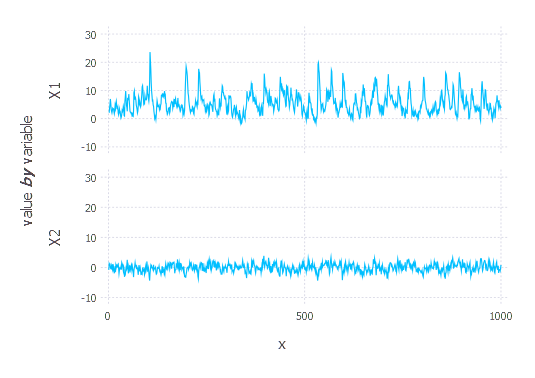

In [24]:
display("text/html","""<math id="M10"><mtable columnalign="left"><mtr><mtd><mtable style="text-align:axis;" equalrows="false" columnlines="" equalcolumns="false" class="array"><mtr><mtd columnalign="left"><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">8</mn><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">65</mn><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub><msup><mrow><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msup><mo mathsize="10.5pt" mathcolor="black">+</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">e</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow></mtd></mtr><mtr><mtd columnalign="left"><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">6</mn><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">+</mo><msub><mrow><mi mathsize="10.5pt" mathcolor="black">e</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow></mtd></mtr><mtr></mtr></mtable></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">9</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

function dataset1(;N=1000)
    noise = rand(Normal(),N+1,2)
    x1 = zeros(N+1,1)
    x2 = zeros(N+1,1)
    for t = 2:(N+1)
        x2[t] = 0.6*x2[t-1] + noise[t,2]
        x1[t] = 0.8*x1[t-1] + 0.65*x2[t-1]^2 + noise[t,1]
    end
    (x1[2:end,:],x2[2:end,:],nothing)
end
(X1,X2) = dataset1()
widedf = DataFrame(x= collect(1:length(X1)), X1=X1[1:end],X2=X2[1:end])
longdf = stack(widedf,[:X1,:X2])
plot(longdf,ygroup="variable",x="x",y="value",Geom.subplot_grid(Geom.line))

まずは、X1→X2の検証

In [25]:
isCausal(X1,X2,d=3)

Cnpmr(X->Y): -0.1306311369683256


false

値がマイナスなのでX1→X2の因果関係はありません。
次にX2→X1の検証

In [26]:
isCausal(X2,X1,d=3)

Cnpmr(X->Y): 0.4527132517698962
1: -0.0850104396039703
2: -0.0854579140825648
3: -0.06642740466762238
4: -0.057358583530641404
5: -0.04912644323743974
6: -0.04912644323743974
7: -0.07793321866931228
8: -0.050824261148861
9: -0.0850104396039703
10: -0.019457394950061786
11: -0.08145544245692973
12: -0.07305769529223785
13: -0.09654476522834572
14: -0.05542213618198124
15: -0.08041021247028776
16: -0.05033230647624253
17: -0.06851407410694774
18: -0.023245066556249926
19: -0.05985362682275324


true

X2→X1の因果関係があります。しかも、Cnpmr値は参考１と一致範囲内です。
次に因果関係のある方向で予測要因の影響度をしらべます。

In [27]:
sensitivity(X1,X2,d=3) #toY=X1, fromX=X2

Q_x1(t-1): 0.1270116553586665
Q_x1(t-2): 0.04839524137610466
Q_x1(t-3): 0.03347992177990148


見事参考１のdataset1の結果と一致で(t-1)のポイントが生成した関数の通り、飛びぬけの影響度となっています。

次にdataset2で多変量の事例を検証しましょう。

x 1 ( t ) = 0.95 2 x 1 ( t − 1 ) − 0.9025 x 1 ( t − 2 ) + e 1 ( t ) x 2 ( t ) = − 0.5 x 1 ( t − 1 ) + e 2 ( t ) x 3 ( t ) = 0.5 x 3 ( t − 1 ) − 0.5 x 2 ( t − 1 ) + e 3 ( t ) ( 10 )

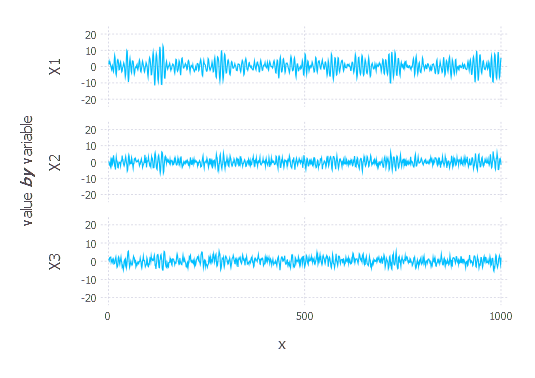

In [28]:
display("text/html","""<math id="M11"><mrow><mtable><mtr><mtd><mtable columnalign="left"><mtr><mtd><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">0.95</mn><msqrt style="color:black"><mn mathsize="10.5pt" mathcolor="black">2</mn></msqrt><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">0.9025</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">2</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><msub><mi mathsize="10.5pt" mathcolor="black">e</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mtd></mtr><mtr><mtd><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">0.5</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><msub><mi mathsize="10.5pt" mathcolor="black">e</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mtd></mtr><mtr><mtd><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">0.5</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">0.5</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><msub><mi mathsize="10.5pt" mathcolor="black">e</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mtd></mtr></mtable></mtd><mtd><mrow><mrow><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mn mathsize="10.5pt" mathcolor="black">10</mn></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd></mtr></mtable></mrow></math>""")

function dataset2(;N = 1000)
    noise = rand(Normal(),N+2,3)
    x1 = zeros(N+2,1)
    x2 = zeros(N+2,1)
    x3 = zeros(N+2,1)
    for t = 3:(N+2)
        x1[t] = 0.95*sqrt(2)*x1[t-1] - 0.9025*x1[t-2] + noise[t,1]
        x2[t] = -0.5*x1[t-1] + noise[t,2]
        x3[t] = 0.5*x3[t-1] - 0.5*x2[t-1] + noise[t,3]
    end
    (x1[3:end,:],x2[3:end,:],x3[3:end,:])
end


(X1,X2,X3) = dataset2()
widedf = DataFrame(x= collect(1:length(X1)), X1=X1[1:end],X2=X2[1:end], X3=X3[1:end])
longdf = stack(widedf,[:X1,:X2,:X3])
plot(longdf,ygroup="variable",x="x",y="value",Geom.subplot_grid(Geom.line))

In [29]:
isCausal(X1,X2,d=3)

Cnpmr(X->Y): 0.671684662174414
1: -0.18305164011163597
2: -0.2041301254118238
3: -0.260890525133038
4: -0.20050125221874063
5: -0.2273640016443483
6: -0.19724852892933792
7: -0.17771813330551128
8: -0.14003230620570442
9: -0.23236018741726963
10: -0.18969858412372836
11: -0.32724034905062943
12: -0.1621860831092942
13: -0.20779459684847085
14: -0.18583530312268123
15: -0.2273640016443483
16: -0.17081209671890846
17: -0.155410989996633
18: -0.20807576811067957
19: -0.26080730081516645


true

In [30]:
isCausal(X1,X3,d=3)

Cnpmr(X->Y): 0.1852700882985855
1: -0.1832403840506568
2: -0.16021595482858547
3: -0.1500438497642182
4: -0.21502180221296693
5: -0.17375901381386755
6: -0.23360530846013075
7: -0.20032885613372817
8: -0.1832403840506568
9: -0.18021569551664052
10: -0.2086838636275143
11: -0.19834488631978325
12: -0.20470052094043029
13: -0.23794232144635014
14: -0.23360530846013075
15: -0.23794232144635014
16: -0.20818850993163376
17: -0.20452101814417786
18: -0.2581948214903939
19: -0.24250779927224972


true

In [31]:
isCausal(X2,X3,d=3)

Cnpmr(X->Y): 0.4915685081813289
1: -0.06358446806362285
2: -0.15042035544807836
3: -0.11332512223768385
4: -0.12797323055268464
5: -0.04466930644860247
6: -0.06137430235113423
7: -0.12496524200271782
8: -0.13944120704619947
9: -0.06358446806362285
10: -0.11044914083123637
11: -0.09446909341670282
12: -0.12472625489838582
13: -0.09446909341670282
14: -0.10908070727846088
15: -0.1469554415123797
16: -0.0802836263861154
17: -0.15042035544807836
18: -0.05855460845758901
19: -0.10599680683634759


true

参考１のFIGURE1(D)(a)と一致しています。
次にX2の情報が分かる場合、X1→X3の因果性があるかどうかを検証（条件付き検証）

In [32]:
#conditional
isCausal(X1,X3,d=3,Z=X2)

Cnpmr(X->Y): -0.21581962879436334


false

X2が分かる場合、X1→X3の因果関係がない結果になります。
これも参考１のFIGURE1(D)(b)と一致しています。生成式(10)の通りです。
影響度もチェックしましょう。

In [33]:
#sensitivity X1->X2
sensitivity(X2,X1,d=3)

Q_x1(t-1): 0.3535896399770177
Q_x1(t-2): 0.09410860094704274
Q_x1(t-3): 0.10359095901217734


In [34]:
#sensitivity X2->X3
sensitivity(X3,X2,d=3)

Q_x1(t-1): 0.34336832098832626
Q_x1(t-2): 0.140831503791619
Q_x1(t-3): 0.10430415578957795


参考１のパターンと一致して、(t-1)時点が飛びぬけ影響が大きいことが分かります。

次に、dataset3を検証しましょう。今度は線形と非線形の因果関係が混在しているケースです。

まずはデータの生成と可視化です。

x 1 ( t ) = 3 . 4 x 1 ( t - 1 ) [ 1 - x 1 2 ( t - 1 ) ] e - x 1 2 ( t - 1 ) + 0 . 4 e 1 ( t ) ( 11 )

x 2 ( t ) = 3.4 x 2 ( t − 1 ) [ 1 − x 2 2 ( t − 1 ) ] e − x 2 2 ( t − 1 )                                            + 0.5 x 1 ( t − 1 ) x 2 ( t − 1 ) + 0.4 e 2 ( t ) ( 12 )

x 3 ( t ) = 3.4 x 3 ( t − 1 ) [ 1 − x 3 2 ( t − 1 ) ] e − x 3 2 ( t − 1 )                       + 0.3 x 2 ( t − 1 ) + 0.5 x 1 2 ( t − 1 ) + 0.4 e 3 ( t ) ( 13 )

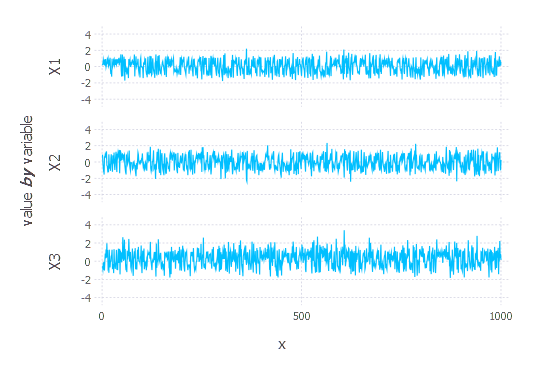

In [35]:
display("text/html","""<math id="M12"><mtable columnalign="left"><mtr><mtd><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">3</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">4</mn><msub><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mrow><mo mathsize="10.5pt" mathcolor="black">[</mo><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">-</mo><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow></mrow><mo mathsize="10.5pt" mathcolor="black">]</mo></mrow><msup><mrow><mi mathsize="10.5pt" mathcolor="black">e</mi></mrow><mrow><mo mathsize="10.5pt" mathcolor="black">-</mo><msubsup><mrow><mi mathsize="10.5pt" mathcolor="black">x</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msubsup><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow></mrow></msup><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">4</mn><msub><mrow><mi mathsize="10.5pt" mathcolor="black">e</mi></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow></msub><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">11</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")
display("text/html","""<math id="M13"><mrow><mtable><mtr><mtd><mtable columnalign="left"><mtr><mtd><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">3.4</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mrow><mo mathsize="10.5pt" mathcolor="black">[</mo><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">−</mo><msubsup><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">]</mo></mrow><msup><mi mathsize="10.5pt" mathcolor="black">e</mi><mrow><mo mathsize="10.5pt" mathcolor="black">−</mo><msubsup><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></msup></mtd></mtr><mtr><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>      </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0.5</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0.4</mn><msub><mi mathsize="10.5pt" mathcolor="black">e</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mtd></mtr></mtable></mtd><mtd><mrow><mrow><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mn mathsize="10.5pt" mathcolor="black">12</mn></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd></mtr></mtable></mrow></math>""")
display("text/html","""<math id="M14"><mrow><mtable><mtr><mtd><mtable columnalign="left"><mtr><mtd><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">3.4</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mrow><mo mathsize="10.5pt" mathcolor="black">[</mo><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">−</mo><msubsup><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">]</mo></mrow><msup><mi mathsize="10.5pt" mathcolor="black">e</mi><mrow><mo mathsize="10.5pt" mathcolor="black">−</mo><msubsup><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">3</mn><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></msup></mtd></mtr><mtr><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext> </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0.3</mn><msub><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">2</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0.5</mn><msubsup><mi mathsize="10.5pt" mathcolor="black">x</mi><mn mathsize="10.5pt" mathcolor="black">1</mn><mn mathsize="10.5pt" mathcolor="black">2</mn></msubsup><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">−</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0.4</mn><msub><mi mathsize="10.5pt" mathcolor="black">e</mi><mn mathsize="10.5pt" mathcolor="black">3</mn></msub><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mtd></mtr></mtable></mtd><mtd><mrow><mrow><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mo mathsize="10.5pt" mathcolor="black">(</mo><mrow><mn mathsize="10.5pt" mathcolor="black">13</mn></mrow><mo mathsize="10.5pt" mathcolor="black">)</mo></mrow></mrow></mtd></mtr></mtable></mrow></math>""")
function dataset3(;N = 1000)
    noise = rand(Normal(),N+1,3)
    x1 = zeros(N+1)
    x2 = zeros(N+1)
    x3 = zeros(N+1)
    for t = 2:(N+1)
        x1[t] = 3.4*x1[t-1]*(1-x1[t-1]^2)*exp(-x1[t-1]^2) + 0.4*noise[t,1]
        x2[t] = 3.4*x2[t-1]*(1-x2[t-1]^2)*exp(-x2[t-1]^2) +
                    0.5*x1[t-1]*x2[t-1]+0.4*noise[t,2]
        x3[t] = 3.4*x3[t-1]*(1-x3[t-1]^2)*exp(-x3[t-1]^2) +
                    0.3*x2[t-1]+0.5*x1[t-1]^2 + 0.4*noise[t,3]
    end
    (x1[2:end,:],x2[2:end,:],x3[2:end,:])
end

(X1,X2,X3) = dataset3()
widedf = DataFrame(x= collect(1:length(X1)), X1=X1[1:end],X2=X2[1:end], X3=X3[1:end])
longdf = stack(widedf,[:X1,:X2,:X3])
plot(longdf,ygroup="variable",x="x",y="value",Geom.subplot_grid(Geom.line))

ランダムにしか見えませんね。

In [36]:
isCausal(X1,X2,d=3)

Cnpmr(X->Y): 0.051409672095286636
1: -0.003161834277715823
2: -0.0049822524491030555
3: -0.0071451676552926465
4: -0.005747349194737617
5: -0.0008126569180557186
6: -0.0013566886911024274
7: -0.0029220282920525845
8: 0.00273962412846018
9: -0.00041423000097645494
10: -0.005352065018849749
11: 0.002930830253506815
12: -0.002935614501621506
13: -0.0071451676552926465
14: -0.0017597575968344775
15: -0.005352065018849749
16: -0.005747349194737617
17: -9.728287967632847e-5
18: -0.0034756553653975415
19: -0.00041423000097645494


true

X1→X2は有意です。

In [37]:
isCausal(X1,X3,d=3)

Cnpmr(X->Y): 0.03990845956605069
1: 0.002686773091822437
2: -0.0020887209927889683
3: -0.004422131232555181
4: -0.002739624204025513
5: -0.0006583081547965291
6: -0.003991307516334886
7: -0.0020312861437972165
8: -0.0004302346258688789
9: -0.004580840822799533
10: -0.004422131232555181
11: -0.008046039704302638
12: -0.005092110828496387
13: 0.0012346128404511058
14: -0.004769718710735653
15: 0.005547270140125792
16: -0.002739624204025513
17: 0.000314318246362787
18: -0.00874154605665981
19: -0.005518931371189397


true

In [38]:
isCausal(X2,X3,d=3)

Cnpmr(X->Y): 0.10255229695465998
1: -0.0032985872651560247
2: -0.004029220236978414
3: -0.0009737364174184533
4: -0.004049499760444935
5: -0.0013404185901591667
6: 0.0015752022556932653
7: -0.004784042731375248
8: -0.0015948092110920633
9: -0.003730042159990315
10: -0.004784042731375248
11: -0.006375117595928247
12: -0.006375117595928247
13: -0.0009737364174184533
14: -0.0016910988146149313
15: -0.008017157896539763
16: -0.0070602438641602094
17: -0.008017157896539763
18: -0.005713060036079319
19: 0.0023712914904417295


true

X1→X3, X2→X3も有意で、
結果は参考１のFIGURE2(D)(a)と一致しています。条件付きの場合も同様です。気になる方は是非実行してみてください。
次にdataset4を検証しましょう。今度はカオス時系列での検証です。

参考１のの意図は時系列間のカップリングの強さしだいでライバルの手法より感度が高いことを見せたいだけなんです。ここではほんの一部でエッセンスだけしらべますのでカップリングの強さcを0.4にします。参考１によるとライバルのカーネルグレンジャー手法(K-GC)はc<0.5では因果関係が検出できないようです。

x ( t ) = 1 . 4 - x ( t - 1 ) 2 + 0 . 3 x ( t - 2 ) ( 14 )

y ( t ) = 1 . 4 - [ c x ( t - 1 ) + ( 1 - c ) y ( t - 1 ) ] y ( t - 1 ) + 0 . 1 y ( t - 2 ) ( 15 )

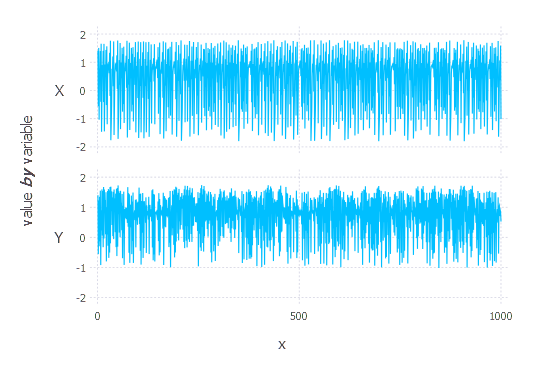

In [39]:
display("text/html","""<math id="M15"><mtable columnalign="left"><mtr><mtd><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">4</mn><mo mathsize="10.5pt" mathcolor="black">-</mo><mi mathsize="10.5pt" mathcolor="black">x</mi><msup><mrow><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow></mrow><mrow><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow></msup><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">3</mn><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow><mo stretchy="false">)</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">14</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")
display("text/html","""<math id="M16"><mtable columnalign="left"><mtr><mtd><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">=</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">4</mn><mo mathsize="10.5pt" mathcolor="black">-</mo><mrow><mo mathsize="10.5pt" mathcolor="black">[</mo><mrow><mi mathsize="10.5pt" mathcolor="black">c</mi><mi mathsize="10.5pt" mathcolor="black">x</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">+</mo><mrow><mo stretchy="false">(</mo><mrow><mn mathsize="10.5pt" mathcolor="black">1</mn><mo mathsize="10.5pt" mathcolor="black">-</mo><mi mathsize="10.5pt" mathcolor="black">c</mi></mrow><mo stretchy="false">)</mo></mrow><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow></mrow><mo mathsize="10.5pt" mathcolor="black">]</mo></mrow><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">1</mn></mrow><mo stretchy="false">)</mo></mrow><mo mathsize="10.5pt" mathcolor="black">+</mo><mn mathsize="10.5pt" mathcolor="black">0</mn><mo mathsize="10.5pt" mathcolor="black">.</mo><mn mathsize="10.5pt" mathcolor="black">1</mn><mi mathsize="10.5pt" mathcolor="black">y</mi><mrow><mo stretchy="false">(</mo><mrow><mi mathsize="10.5pt" mathcolor="black">t</mi><mo mathsize="10.5pt" mathcolor="black">-</mo><mn mathsize="10.5pt" mathcolor="black">2</mn></mrow><mo stretchy="false">)</mo></mrow></mtd><mtd><mstyle class="text" mathsize="10.5pt" mathcolor="black"><mtext>    </mtext></mstyle><mrow><mo mathsize="10.5pt" mathcolor="black" stretchy="false">(</mo><mn mathsize="10.5pt" mathcolor="black">15</mn><mo mathsize="10.5pt" mathcolor="black" stretchy="false">)</mo></mrow></mtd></mtr></mtable></math>""")

function dataset4(;c=0.4,N = 1000)
    x = zeros(N+2,1)
    y = zeros(N+2,1)
    for t = 3:(N+2)
        x[t] = 1.4 - x[t-1]^2 + 0.3*x[t-2]
        y[t] = 1.4 -
            (c*x[t-1] + (1-c)*(y[t-1]))*y[t-1] +
            0.1*y[t-2]
    end
    (x[3:end,:],y[3:end,:],nothing)
end

(X,Y) = dataset4()
widedf = DataFrame(x= collect(1:length(X)), X=X[1:end],Y=Y[1:end])
longdf = stack(widedf,[:X,:Y])
plot(longdf,ygroup="variable",x="x",y="value",Geom.subplot_grid(Geom.line))


In [40]:
isCausal(X,Y,d=3)

Cnpmr(X->Y): 0.7581493700934339
1: -0.008608600123037246
2: -0.01101211464036384
3: 0.007645316987568852
4: -0.006377665752378722
5: -0.008070308926483772
6: 0.0011559154974909141
7: -0.006920034980334764
8: -0.007604836657581111
9: -0.002748833395877651
10: -0.0007645988243322184
11: -0.006384200469366515
12: 0.0014060965749392643
13: 0.010500464127161716
14: -0.007604836657581111
15: -0.003604460430469164
16: -0.006416145518451435
17: -0.006384200469366515
18: -0.0007645988243322184
19: 0.009192094715089761


true

見事X→Yの因果関係があるという結果です。

In [41]:
isCausal(Y,X,d=3)

Cnpmr(X->Y): 0.007377674002540528
1: -0.002438229657170665
2: -0.0032021063915944896
3: -0.013244041046412908
4: -0.005800064406072791
5: 0.006682642614476876
6: -0.011904718906337436
7: -0.012066263293761502
8: -0.00905012623479991
9: -0.007948363639166234
10: -0.005800064406072791
11: -0.010167604179355206
12: -0.0007924427535106275
13: -0.0018566429938436464
14: 0.0019055036401654836
15: -0.013244041046412908
16: -0.01618507857523898
17: -0.006937188374138291
18: -0.00892753470201335
19: -0.0017365856333242862


true

Y→X因果関係は何回かやりますと有意したりしなかったりします。これは式上、フィードバック的な因果関係を持たしていないが、別の論文でこのようなカオス時系列にについて、なぜか因果関係があるようになってしまう解説があるようです。
いずれにしても因果関係の強さはX→Yの方向よりも低いと参考１の結果と一致しています。
検証の続きがありますが、長くなってしまいますので検証はここまでにしておきましょう。

## 考察
立役者はいうまでもなく、NPMRモデルにあります。本家の資料を見た限り利用シナリオは、モデル対象のデータが十分に多く、予測要因がお互いに響きあって、その関係性がハッキリわかっていなくて、どうしようもない時に、最後のリソースとして利用するものとしています。ところで参考１では、NPMRモデルの守備範囲が意外と広いと判明、めでたく因果関係検出に適していると報告されました。

実際にやってみたところ、おもちゃケースは問題なく再現できました。あくまで、NPMRモデルの最適化をしなくても因果関係のパターンを正しく検出できる範囲で用意されたにすぎません。論文の第４節「Discussion」では、注意事項やベストプラクティス、さらには、課題となっているケースなどが念入りに語られています。初期の発見ではありますが、因果関係検出としての様々な可能性を見せています。アイディア次第でコスパのよいツールに拡張できそうな気がします。

参考１の手法が簡単で高度な知識が必要としませんでしたが、計算量はデータの長さの二乗オーダーでしたね。長い時系列の場合はちょっと時間がかかります。スケールしにくいかもしれませんが、処理工程の依存関係があまりなく、並列処理は簡単にできそうです。


## 最後に

ここまで全部読んでいただけた方は、大変心から尊敬しております。弊社近くまで来られた場合は是非ランチに行きましょう。今後ともよろしくお願いいたします。

# 参考
1. Nicolaou Nicoletta, Constandinou Timothy G.: "A Nonlinear Causality Estimator Based on Non-Parametric Multiplicative Regression", Frontiers in Neuroinformatics vol.10, 2016 https://doi.org/10.3389/fninf.2016.00019
2. Ryan G. James, Nix Barnett, James P. Crutchfield: "Information Flows? A Critique of Transfer Entropies", Phys. Rev. Lett. 116, 238701 (2016)
3. McCune, Bruce: "Non-parametric habitat models with automatic interactions", Journal of Vegetation Science 17: 819-830, 2006

以上